In [1]:
from qpms import Particle, CTMatrix, BaseSpec, FinitePointGroup, ScatteringSystem, TMatrixInterpolator, dbgmsg_enable, dbgmsg_disable, dbgmsg_active, BesselType,  eV, ℏ , TMatrixGenerator, c
from qpms.symmetries import point_group_info
from qpms.cymaterials import EpsMuGenerator, EpsMu, LorentzDrudeModel, lorentz_drude
from qpms.cybspec import BaseSpec
import numpy as np


In [33]:
edge_len = 3.0e-6
edge_npart = 7
ω = 2.1*eV/ℏ # Currently, we need to set the frequency first and then repeat the whole process with another if needed
refractive_index = 1.52 # for background medium

h = 60e-9 # Edge particle height
r = 60e-9 # Edge particle radius
R = 150e-9 # Central particle radius

medium = EpsMu(refractive_index**2) # non-lossy background medium with constant refr. index
metal = lorentz_drude['Au']

In [34]:
# T-matrix generators, currently used only once
tmgen_edge = TMatrixGenerator.cylinder(medium, metal, r, h, lMax_extend=6)
tmgen_central = TMatrixGenerator.sphere(medium, metal, R)

In [35]:
# global symmetry group of the system
sym = FinitePointGroup(point_group_info['D3h'])
# cutoff for the smaller particles
bspec_edge = BaseSpec(lMax=3)
# let the central particle be larger, hence we need larger lMax
bspec_central = BaseSpec(lMax=6)

# T-matrices
T_edge = tmgen_edge(bspec_edge, ω)
T_central = tmgen_central(bspec_central, ω)

# Generate the particle list:
particles = [Particle((0, 0), T_central)]
y = edge_len / (2*3**.5)
for x in np.linspace(-edge_len/2,edge_len/2,edge_npart):
    particles.append(Particle((x,y), T_edge))
    particles.append(Particle((x,-y), T_edge))
    
# Ready to go
ss = ScatteringSystem(particles, sym)

Text(0, 0.5, '$y/\\mathrm{\\mu m}$')

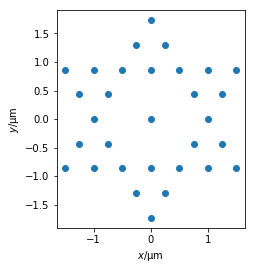

In [44]:
# Check the generated positions
%matplotlib inline
from matplotlib import pyplot as plt
pos = ss.positions[:,:2]
f = plt.figure()
ax = f.add_subplot(111)
ax.plot(pos[:,0]/1e-6, pos[:,1]/1e-6, 'o')
ax.set_aspect('equal')
ax.set_xlabel('$x/\mathrm{\mu m}$')
ax.set_ylabel('$y/\mathrm{\mu m}$');

In [37]:
# Let's solve some scattering problems:
wavenumber = medium.k(ω).real # Currently, ScatteringSystem does not "remember" frequency nor wavenumber

#LU = [ss.scatter_solver(wavenumber, iri) for iri in range(ss.nirreps)]
LU_full = ss.scatter_solver(wavenumber)

# Try with y-polarised waves with incident direction 
# rotated along the y axis in the interval [-π/4, π/4]
sinalpha_list = np.linspace(-1,1,51)
σ_ext_list = list()
σ_scat_list = list()

for sinalpha in sinalpha_list:
    ã = ss.planewave_full(k_cart=(sinalpha, 0, 1), E_cart=(0, 1, 0))
    Tã = ss.apply_Tmatrices_full(ã)
    f = LU_full(Tã)
    translation_matrix = ss.translation_matrix_full(wavenumber, BesselType.REGULAR) + np.eye(ss.fecv_size) # ss.translation_matrix_full() does not fill the diagonal elements
    σ_ext = -np.vdot(ã, f).real/wavenumber**2
    σ_scat = np.vdot(f,np.dot(translation_matrix, f))/wavenumber**2
    σ_ext_list.append(σ_ext)
    σ_scat_list.append(σ_scat)
σ_ext_list = np.array(σ_ext_list)
σ_scat_list = np.array(σ_scat_list)
σ_abs_list = σ_ext_list - σ_scat_list
    


/u/46/necadam1/unix/.local/lib/python3.5/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


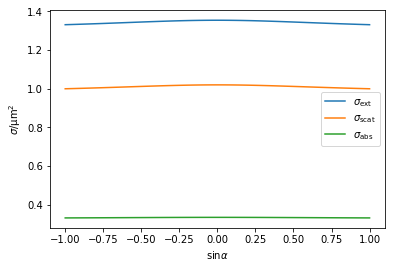

In [52]:
f = plt.figure()
ax = f.add_subplot(111)
ax.plot(sinalpha_list, σ_ext_list*1e12,label='$\sigma_\mathrm{ext}$')
ax.plot(sinalpha_list, σ_scat_list*1e12, label='$\sigma_\mathrm{scat}$')
ax.plot(sinalpha_list, σ_abs_list*1e12, label='$\sigma_\mathrm{abs}$')
ax.legend()
ax.set_xlabel('$\sin\\alpha$')
ax.set_ylabel('$\sigma/\mathrm{\mu m^2}$');